# Tail Segmentation 

**The following notebook illustrate the `TailSegmentation` class.**

* Loading dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from megabouts.tracking_data import TrackingConfig, load_example_data, FullTrackingData
from megabouts.config import TailPreprocessingConfig, TailSegmentationConfig
from megabouts.preprocessing import TailPreprocessing
from megabouts.segmentation import Segmentation

## Loading Data and Preprocessing

* TrackingConfig and TrackingData similar to [tutorial_Tail_Preprocessing](./tutorial_Tail_Preprocessing.ipynb)

In [2]:
df_recording, fps, mm_per_unit = load_example_data("fulltracking_posture")

tracking_cfg = TrackingConfig(fps=fps, tracking="full_tracking")

head_x = df_recording["head_x"].values * mm_per_unit
head_y = df_recording["head_y"].values * mm_per_unit
head_yaw = df_recording["head_angle"].values
tail_angle = df_recording.filter(like="tail_angle").values

tracking_data = FullTrackingData.from_posture(
    head_x=head_x, head_y=head_y, head_yaw=head_yaw, tail_angle=tail_angle
)
t = np.arange(tracking_data.T) / tracking_cfg.fps

tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)

tail_preprocessing_cfg = TailPreprocessingConfig(
    fps=tracking_cfg.fps,
    num_pcs=4,
    savgol_window_ms=15,
    tail_speed_filter_ms=100,
    tail_speed_boxcar_filter_ms=25,
)
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)

In [3]:
tail.df.head(5)

angle                                                              \
   segments                                                               
          0         1         2         3         4         5         6   
0 -0.101865 -0.092813 -0.107645 -0.110575 -0.047699 -0.145887 -0.130414   
1 -0.082618 -0.087957 -0.096951 -0.092459 -0.119418 -0.043354 -0.099788   
2 -0.093377 -0.095235 -0.094292 -0.105936 -0.073785 -0.084193 -0.144378   
3 -0.092590 -0.083650 -0.100938 -0.088223 -0.097370 -0.099559 -0.101538   
4 -0.086849 -0.081982 -0.096705 -0.118475 -0.046264 -0.136459 -0.115412   

                           ... angle_smooth                                \
                           ...     segments                                 
          7         8   9  ...            2         3         4         5   
0 -0.058892 -0.128705 NaN  ...    -0.051057 -0.055168 -0.055898 -0.061701   
1 -0.101741 -0.171555 NaN  ...    -0.046070 -0.052906 -0.056578 -0.063577   
2 -0.112398 -0.042585 NaN  ...    -0.041909 -0.050905 -0.056916 -0.064832   
3 -0.091272 -0.021459 NaN  ...    -0.038574 -0.049166 -0.056913 -0.065467   
4 -0.085300 -0.015487 NaN  ...    -0.036064 -0.047688 -0.056569 -0.065483   

                                          no_tracking vigor  
                                                             
          6         7         8         9                    
0 -0.061091 -0.069420 -0.115014  0.000183        True   NaN  
1 -0.062286 -0.064780 -0.091617  0.000321        True   NaN  
2 -0.062943 -0.060658 -0.072246  0.000430        True   NaN  
3 -0.063063 -0.057053 -0.056900  0.000512        True   NaN  
4 -0.062646 -0.053965 -0.045579  0.000565        True   NaN  

[5 rows x 32 columns]

# Segmentation using tail vigor

* Set the threshold to 20:

In [4]:
tail_segmentation_cfg = TailSegmentationConfig(fps=tracking_cfg.fps, threshold=20)

* Apply segmentation to `tail.vigor`:

In [5]:
segmentation_function = Segmentation.from_config(tail_segmentation_cfg)
segments = segmentation_function.segment(tail.vigor)

* We can visualize the results of the segmentation:

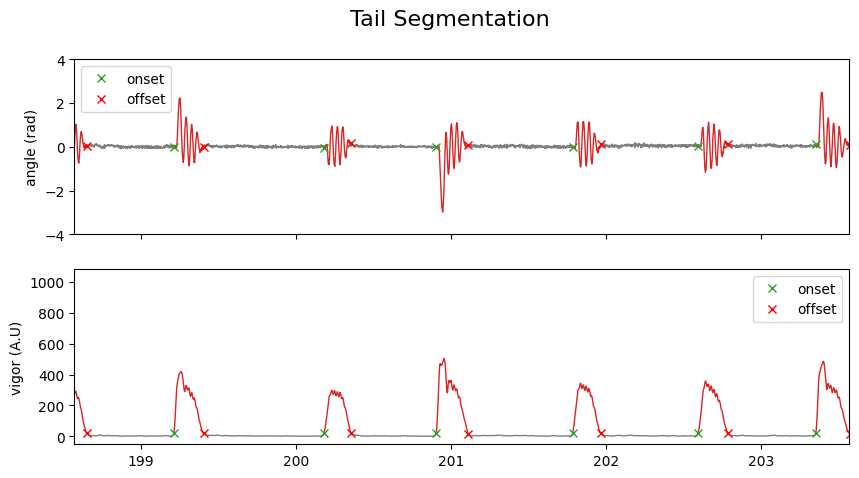

In [6]:
is_bouts = np.zeros(tracking_data.T, dtype=bool)
# Set to True for the indices within the bouts
for on_, off_ in zip(segments.onset, segments.offset):
    is_bouts[on_:off_] = True

IdSt = 139000
Duration = 5 * tracking_cfg.fps

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
fig.suptitle("Tail Segmentation", fontsize=16)

x = np.copy(tracking_data._tail_angle[:, 7])
x_bouts = np.where(is_bouts, x, np.nan)
x_nobouts = np.where(~is_bouts, x, np.nan)

ax[0].plot(t, x_nobouts, "tab:gray", lw=1)
ax[0].plot(t, x_bouts, "tab:red", lw=1)
ax[0].plot(t[segments.onset], x[segments.onset], "x", color="tab:green", label="onset")
ax[0].plot(t[segments.offset], x[segments.offset], "x", color="red", label="offset")
ax[0].set(ylabel="angle (rad)", ylim=(-4, 4))
ax[0].legend()

x = np.copy(tail.vigor)
x_bouts = np.where(is_bouts, x, np.nan)
x_nobouts = np.where(~is_bouts, x, np.nan)

ax[1].plot(t, x_nobouts, "tab:gray", lw=1)
ax[1].plot(t, x_bouts, "tab:red", lw=1)
ax[1].plot(t[segments.onset], x[segments.onset], "x", color="tab:green", label="onset")
ax[1].plot(t[segments.offset], x[segments.offset], "x", color="red", label="offset")
ax[1].set(ylabel="vigor (A.U)")
ax[1].legend()

t = np.arange(tracking_data.T) / tracking_cfg.fps

ax[1].set_xlim(t[IdSt], t[IdSt + Duration])
plt.show()

* To find the ideal segmentation threshold for your dataset, it is useful to compute the number of bouts detected as a function of the threshold:

In [7]:
# Number of bouts as function of threshold:
thresh_list = np.linspace(4, 400, 500)
num_bouts = np.zeros_like(thresh_list)

for i, thresh in enumerate(thresh_list):
    tail_segmentation_cfg = TailSegmentationConfig(
        fps=tracking_cfg.fps, threshold=thresh
    )
    segmentation_function = Segmentation.from_config(tail_segmentation_cfg)
    segments = segmentation_function.segment(tail.vigor)
    num_bouts[i] = len(segments.onset)


* For very small threshold values, too many bouts are detected, while for large threshold values, no bouts are detected. There is an optimal range on the plateau between these extremes where a suitable threshold can be found:

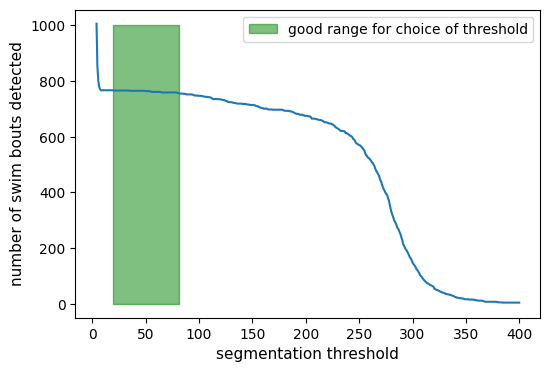

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(thresh_list, num_bouts)

ax.fill_between(
    thresh_list,
    0,
    1000,
    where=(num_bouts < 767) & (num_bouts > 755),
    color="green",
    alpha=0.5,
    label="good range for choice of threshold",
)
ax.legend()
ax.set_ylabel("number of swim bouts detected", fontsize=11)
ax.set_xlabel("segmentation threshold", fontsize=11)
plt.show()